In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('crypto.csv', header=[0, 1], index_col=0, parse_dates=[0])
# df.head()

In [3]:
df.columns = ['_'.join(col).strip() for col in df.columns].copy()
# df.head()

In [4]:
df = df[[col for col in df.columns if col.startswith('close_')]].copy()
# df.head()

In [5]:
df = df.dropna().copy()
# df.head()

In [6]:
for lag in [1, 7, 60]:
    for col in df.columns:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

In [7]:
df = df.reset_index()

In [8]:
df = df.drop('Date', axis=1).copy()

In [9]:
df = df.dropna().copy()
# df.head()

In [10]:
# Step 3: Select the 1-year period (last 365 days: 2024-04-01 to 2025-03-31)
df_1year = df.tail(365).copy()
print("1-year period shape:", df_1year.shape)
print("1-year period date range:", df_1year.index.min(), "to", df_1year.index.max())

1-year period shape: (365, 48)
1-year period date range: 1452 to 1816


In [11]:
features = [col for col in df_1year.columns if col != 'close_btc']

X_1year = df_1year[features]

In [12]:
from joblib import load

In [13]:
# Step 5: Load the saved scaler and polynomial converter
model = load('elastic_net_60_btc.joblib')
scaler = load('scaler_60_btc.joblib')
poly_converter = load('poly_60_btc.joblib')

In [14]:
scaled_data = scaler.transform(X_1year)

In [15]:
poly_conveted_data = poly_converter.transform(scaled_data)
poly_conveted_data.shape

(365, 1175)

In [28]:
price_60 = model.predict(poly_conveted_data)

In [31]:
actual_prices = df['close_btc'].iloc[-365:-60].values  # Length: 305
predicted_prices = price_60[:-60]  # First 305 predictions to match actual prices

# Step 2: Detect trading signals
buy_signals = []
sell_signals = []
for i in range(len(actual_prices)):
    actual = actual_prices[i]
    predicted = predicted_prices[i]
    diff_percent = (predicted - actual) / actual * 100
    if diff_percent > 5:  # Buy if predicted is 5% above actual
        buy_signals.append((i + 1, actual))  # Day and price for the marker
    elif diff_percent < -5:  # Sell if predicted is 5% below actual
        sell_signals.append((i + 1, actual))

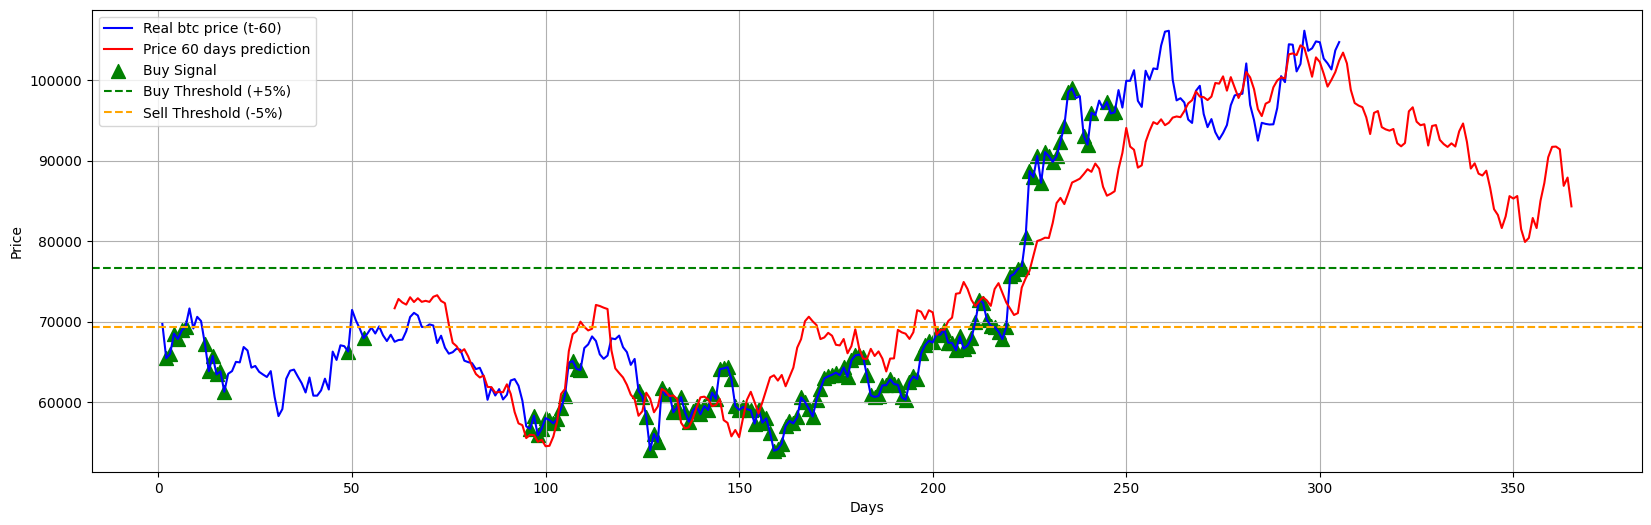

In [32]:
# Adjust the range to match the length of df['close_btc'].iloc[-365:-60]
plt.figure(figsize=(20, 6))

# Plot actual prices (shifted back 60 days)
plt.plot(range(1, 306), df['close_btc'].iloc[-365:-60], color='blue', label='Real btc price (t-60)')

# Plot predicted prices (only the first 305 predictions to match)
plt.plot(range(61, 366), price_60[:-60], color='red', label='Price 60 days prediction')

# Add buy signals (green upward triangles)
if buy_signals:
    buy_days, buy_prices = zip(*buy_signals)
    plt.scatter(buy_days, buy_prices, color='green', marker='^', s=100, label='Buy Signal')

plt.xlabel('Days')
plt.ylabel('Price')
plt.grid(True)
plt.legend()

# Add threshold lines for trading signals
avg_price = df['close_btc'].iloc[-365:-60].mean()
plt.axhline(y=avg_price * 1.05, color='green', linestyle='--', label='Buy Threshold (+5%)')
plt.axhline(y=avg_price * 0.95, color='orange', linestyle='--', label='Sell Threshold (-5%)')

plt.legend()
plt.show()